In [1]:
!git clone https://github.com/loganrooks/CSC411.git

Cloning into 'CSC411'...
remote: Counting objects: 1810, done.
remote: Compressing objects: 100% (896/896), done.
remote: Total 1810 (delta 900), reused 1794 (delta 899), pack-reused 15
Receiving objects: 100% (1810/1810), 15.85 MiB | 45.32 MiB/s, done.
Resolving deltas: 100% (901/901), done.


## Part 0: Preparing Data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import time

from scipy.io import loadmat
from scipy.misc import imread
from scipy.misc import imresize
from scipy.ndimage import filters
import matplotlib.image as mpimg

import urllib
%matplotlib inline

In [0]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [10]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(mnist["data"], mnist["target"], train_size=0.8, random_state=411)
X, y, X_test, y_test = X/255.0, y, X_test/255.0, y_test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=411)
print X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(44800, 784) (44800,) (11200, 784) (11200,) (14000, 784) (14000,)


## Part 1: Visualizing the Dataset

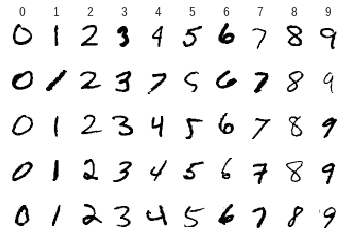

In [24]:
n_samples = 5
n_classes = 10
for number in range(n_classes):
  samples = X_train[y_train==number][:n_samples]
  for sample_idx in range(n_samples):
    index = number + sample_idx * n_classes + 1
    fig = plt.subplot(n_samples,n_classes, index)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.imshow(samples[sample_idx].reshape(28,28))
    if sample_idx == 0: 
      plt.title("{}".format(number))

In [0]:
def one_hot_encode(labels):
  n_out = np.unique(labels).shape[0]
  encoding = np.eye(n_out)
  y = np.array([encoding[int(label)] for label in labels]).reshape(-1, n_out)
  return y

In [33]:
y_train_one_hot = one_hot_encode(y_train)
y_valid_one_hot = one_hot_encode(y_valid)
print y_train_one_hot[:5]

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [0]:
def softmax(x):
  exp = np.exp(x)
  return exp / exp.sum()

In [0]:
class cross_entropy():
  def __init__(self, model, weight_decay=0.0001):
    self.model = model
    self.weight_decay = weight_decay
    
  def gradients(self, X, y_pred, y):
    n_samples = y.shape[0]
    # print(X.shape)
    # print(self.model.weights.shape)
    w_gradients = (1.0/n_samples) * np.matmul((y_pred - y).T, X) + self.weight_decay * self.model.weights
    b_gradients = np.sum(y_pred - y, axis=0).reshape(-1,1)/n_samples
    return w_gradients, b_gradients
  
  def calculate(self, y_pred, y):
    n_samples = y.shape[0]
    return -np.sum(y * np.log(y_pred))/n_samples + (0.5)*self.weight_decay*np.sum(np.matmul(self.model.weights.T, self.model.weights))

In [0]:
class OneLayerNetwork():
  def __init__(self, n_inputs, n_outputs, weights=None, biases=None):
    # Initialize weights with predefined weights or use He Initialization
    self.weights = weights if weights != None else np.random.randn(n_outputs, n_inputs) / np.sqrt(n_inputs)
    # Initialize biases with zeroes since symmetry breaking has already been done 
    self.biases = biases if biases != None else np.zeros((n_outputs, 1))
    self.epochs = 0                                          
    
  def forward(self, X):
    logits = np.matmul(X, self.weights.T) + self.biases.T
    y_pred = softmax(logits)                                                     
    return y_pred
  
  def train(self, X_train, y_train, X_valid, y_valid, init_alpha=0.1, weight_decay=0.0001, batch_size=32, n_epochs=10, steps_until_eval=100, loss=cross_entropy):
    n_samples = X_train.shape[0]
    self.loss = loss(self, weight_decay)
    alpha = init_alpha
    best_loss = np.infty
    evals_since_last_best = 0
    for epoch in range(n_epochs):
      step = 0                                                   
      batch_indices = np.random.permutation(range(n_samples)).reshape(-1,batch_size)
      X_batches = tuple(X_train[batch_indices, :]) 
      y_batches = tuple(y_train[batch_indices, :])  
      # print batches
      for batch in zip(X_batches, y_batches):
        X_batch = batch[0]
        y_batch = batch[1]
        # print batch[0].shape
        # print batch[1].shape
        y_pred = self.forward(X_batch)
        gradients = self.loss.gradients(X_batch, y_pred, y_batch)
        # print gradients[1].shape
        self.weights -= alpha*gradients[0]
        self.biases -= alpha*gradients[1]
        step += 1
        
        if step % 100 == 0:
          print "Epoch: {}, Step: {} \n".format(epoch, step)
          train_accuracy, train_loss = self.evaluation(y_pred, y_batch, self.loss)
          print "Training Set: Accuracy: {}, Loss: {} \n".format(train_accuracy, train_loss)
          y_pred_valid = self.forward(X_valid)
          valid_accuracy, valid_loss = self.evaluation(y_pred_valid, y_valid, self.loss)
          print "Validation Set: Accuracy: {}, Loss: {} \n".format(valid_accuracy, valid_loss)
          
          if valid_loss < best_loss:
            evals_since_last_best = 0
            best_loss = valid_loss
            best_accuracy = valid_accuracy
            best_params = [self.weights, self.biases]
          else:
            evals_since_last_best += 1
            
          if evals_since_last_best > 4:
            alpha /= 10     
            
          print "Best Accuracy: {}, Best Loss: {} \n\n".format(best_accuracy, best_loss)
      for category in range(self.weights.shape[0]):
        plt.imsave("weights_c{}_t{}_v{}_e{}.jpg".format(category, train_accuracy, valid_accuracy, epoch), self.weights[category, :].reshape(28,28))        
    self.weights = best_params[0]
    self.biases = best_params[1]
          
                                                                                                                 
  def evaluation(self, y_pred, y, loss):
    n_samples = y.shape[0]                                                                                                        
    n_correct = float(np.equal(np.argmax(y_pred, axis=1), np.argmax(y, axis=1)).sum())
    accuracy = n_correct / n_samples
    return accuracy, loss.calculate(y_pred, y)                                                                                                                                                    

In [230]:
n_inputs = X_train.shape[1]
n_outputs = y_train_one_hot.shape[1]
print n_inputs, n_outputs

784 10


In [0]:
net = OneLayerNetwork(n_inputs, n_outputs)

In [232]:
net.train(X_train, y_train_one_hot, X_valid, y_valid_one_hot)

Epoch: 0, Step: 100 

Training Set: Accuracy: 0.09375, Loss: 5.7602857028 

Validation Set: Accuracy: 0.104017857143, Loss: 11.627183369 

Best Accuracy: 0.104017857143, Best Loss: 11.627183369 


Epoch: 0, Step: 200 

Training Set: Accuracy: 0.09375, Loss: 5.76327135093 

Validation Set: Accuracy: 0.110803571429, Loss: 11.6295038484 

Best Accuracy: 0.104017857143, Best Loss: 11.627183369 


Epoch: 0, Step: 300 

Training Set: Accuracy: 0.15625, Loss: 5.72755441006 

Validation Set: Accuracy: 0.110803571429, Loss: 11.6401425607 

Best Accuracy: 0.104017857143, Best Loss: 11.627183369 


Epoch: 0, Step: 400 

Training Set: Accuracy: 0.125, Loss: 5.79134557913 

Validation Set: Accuracy: 0.110803571429, Loss: 11.6445016136 

Best Accuracy: 0.104017857143, Best Loss: 11.627183369 


Epoch: 0, Step: 500 

Training Set: Accuracy: 0.0625, Loss: 5.85529423957 

Validation Set: Accuracy: 0.110803571429, Loss: 11.6529845154 

Best Accuracy: 0.104017857143, Best Loss: 11.627183369 


Epoch: 0, 

Validation Set: Accuracy: 0.110803571429, Loss: 11.6692985326 

Best Accuracy: 0.104017857143, Best Loss: 11.627183369 


Epoch: 3, Step: 1100 

Training Set: Accuracy: 0.15625, Loss: 5.80030106125 

Validation Set: Accuracy: 0.110803571429, Loss: 11.6692985326 

Best Accuracy: 0.104017857143, Best Loss: 11.627183369 


Epoch: 3, Step: 1200 

Training Set: Accuracy: 0.15625, Loss: 5.78719659112 

Validation Set: Accuracy: 0.110803571429, Loss: 11.6692985326 

Best Accuracy: 0.104017857143, Best Loss: 11.627183369 


Epoch: 3, Step: 1300 

Training Set: Accuracy: 0.09375, Loss: 5.89028594666 

Validation Set: Accuracy: 0.110803571429, Loss: 11.6692985326 

Best Accuracy: 0.104017857143, Best Loss: 11.627183369 


Epoch: 3, Step: 1400 

Training Set: Accuracy: 0.1875, Loss: 5.74490100107 

Validation Set: Accuracy: 0.110803571429, Loss: 11.6692985326 

Best Accuracy: 0.104017857143, Best Loss: 11.627183369 


Epoch: 4, Step: 100 

Training Set: Accuracy: 0.09375, Loss: 5.7978159732 

Val

Validation Set: Accuracy: 0.110803571429, Loss: 11.6692985326 

Best Accuracy: 0.104017857143, Best Loss: 11.627183369 


Epoch: 7, Step: 400 

Training Set: Accuracy: 0.0625, Loss: 5.86247794413 

Validation Set: Accuracy: 0.110803571429, Loss: 11.6692985326 

Best Accuracy: 0.104017857143, Best Loss: 11.627183369 


Epoch: 7, Step: 500 

Training Set: Accuracy: 0.125, Loss: 5.74541345917 

Validation Set: Accuracy: 0.110803571429, Loss: 11.6692985326 

Best Accuracy: 0.104017857143, Best Loss: 11.627183369 


Epoch: 7, Step: 600 

Training Set: Accuracy: 0.0625, Loss: 5.88244962458 

Validation Set: Accuracy: 0.110803571429, Loss: 11.6692985326 

Best Accuracy: 0.104017857143, Best Loss: 11.627183369 


Epoch: 7, Step: 700 

Training Set: Accuracy: 0.0625, Loss: 5.83403735918 

Validation Set: Accuracy: 0.110803571429, Loss: 11.6692985326 

Best Accuracy: 0.104017857143, Best Loss: 11.627183369 


Epoch: 7, Step: 800 

Training Set: Accuracy: 0.03125, Loss: 5.87442333892 

Validation

## Part 8: PyTorch Neural Network

In [3]:
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.1-cp27-cp27mu-linux_x86_64.whl 
!pip install torchvision 
!pip install pillow==4.0.0

    100% |████████████████████████████████| 496.9MB 67.3MB/s 
    100% |████████████████████████████████| 51kB 2.9MB/s 
    100% |████████████████████████████████| 5.9MB 212kB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 5.6MB 206kB/s 
  Found existing installation: Pillow 5.0.0
    Uninstalling Pillow-5.0.0:
      Successfully uninstalled Pillow-5.0.0


In [0]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T
import torchvision.datasets as dsets
import torch.nn.parallel
import torch.utils.data

# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

In [0]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [0]:
class Swish(nn.Module):
  def __init__(self, beta=1.0):
    super(Swish, self).__init__()
    self.beta = beta
  
  def forward(self, x):
    return x * sigmoid(self.beta * x)
    

In [0]:
n_inputs = 32*32
n_outputs = 6
n_hidden = 40

model = torch.nn.Sequential(
        torch.nn.Linear(n_inputs, n_hidden),
        torch.nn.BatchNorm1d(n_hidden),
        torch.nn.ELU(),
        torch.nn.Linear(n_hidden, n_outputs)
)
if use_cuda:
  model.cuda()

In [0]:
loss_fn = torch.nn.CrossEntropyLoss()

In [0]:
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
def data_label_split(dataset, label_map, one_hot_code=False, dtype=torch.FloatTensor):
    data = dataset["Data"][dataset["Label"].isin(label_map.keys())]
    labels = np.array([label_map.get(label) for label in dataset["Label"][dataset["Label"].isin(label_map.keys())]])
    n_out = labels.shape[1]
        
    flat_data = np.array(data.tolist())
    X = torch.FloatTensor(np.concatenate((np.ones((flat_data.shape[0], 1)), flat_data), axis=1)).type(dtype)
    y = torch.FloatTensor(np.array(labels).reshape(-1, n_out)).type(dtype)
    return X, y

In [0]:
actors = ['Lorraine Bracco', 'Peri Gilpin', 'Angie Harmon', 'Alec Baldwin', 'Bill Hader', 'Steve Carell']

In [0]:
directory = "/content/CSC411/Project 2/"
# Reformatting dataset
sets = ["train", "validation", "test"]
dataset = {set_type: pd.DataFrame(columns=["Data", "Label"]) for set_type in sets}

n_samples = {"train": 120, "validation": 10, "test": 10, "total": 140}
# n_samples = {"train": 2, "validation": 10, "test": 10, "total": 140}

np.random.seed(411)
for actor in actors:
    name = actor.split()[1].lower()
    # Create random permutation of indices to load images in random order
    indices = np.random.permutation(range(n_samples["total"]))
    i = 0 # Required to keep track of current image No.
    for set_type in sets:
        set_actor_data = []
        for sample in range(n_samples[set_type]):
            filename = name + str(indices[i]) + '.jpg'
            img_data = imread(directory + "cropped/" + filename).flatten() / 255.0
            set_actor_data.append([img_data] + [name])
            i += 1
        set_actor_data = pd.DataFrame(set_actor_data, columns = list(dataset[set_type]))
        dataset[set_type] = pd.concat([dataset[set_type], set_actor_data], ignore_index=True)

In [0]:
train = dataset["train"].sample(frac=1, random_state=411)
validation = dataset["validation"].sample(frac=1, random_state=411)
test = dataset["test"].sample(frac=1, random_state=411)

In [0]:
label_map = {'bracco': [1, 0, 0, 0, 0, 0],
            'gilpin': [0, 1, 0, 0, 0, 0],
            'harmon': [0, 0, 1, 0, 0, 0],
            'baldwin': [0, 0, 0, 1, 0, 0],
            'hader': [0, 0, 0, 0, 1, 0],
            'carell': [0, 0, 0, 0, 0, 1]}   
X_train, y_train = data_label_split(train, label_map)
X_valid, y_valid = data_label_split(validation, label_map, dtype=Tensor)

In [0]:
def get_batches(X, y, batch_size, dtype=torch.FloatTensor):
  n_samples = X.shape[0]
  
  if n_samples % batch_size != 0:
    assert ValueError
    
  batch_indices = np.random.permutation(range(n_samples)).reshape(-1,batch_size)
  X_batches = torch.FloatTensor(X[batch_indices,:]).type(dtype)
  y_batches = torch.FloatTensor(y[batch_indices,:]).type(dtype)
  
  return X_batches, y_batches

In [51]:
batch_size = 16
n_samples = X_train.shape[0]
n_batches = int(n_samples / batch_size)
n_epochs = 300

for epoch in range(n_epochs):
  X_batches, y_batches = get_batches(X_train, y_train, batch_size, dtype=Tensor)
  step = 0
  running_loss = 0.0
  for X_batch, y_batch in zip(X_batches, y_batches):
    y_pred = model(Variable(X_batch))
    loss = loss_fn(y_pred, y_batch)
    running_loss += loss
    model.zero_grad()  
    loss.backward()    
    optimizer.step()   
    step += 1
    if step % 200 == 0:
      avg_loss = running_loss / 200.0
      y_pred_valid = model(Variable(X_valid))
      valid_loss = loss_fn(y_pred_valid, y_valid)
      
      n_samples = X_valid.shape[0]
      n_correct = (y_pred_valid == y_valid).sum()
      valid_accuracy = n_correct / n_samples
      
      print("Epoch: {}, Step: {} \nLoss: {}, Accuracy: {}, Validation Loss: {}, Validation Accuracy: {}".format(epoch, step, avg_loss, validation_loss))
      
      

RuntimeError: ignored